In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
import cleanup

In [2]:
#cleanup.clean_up()

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, class_names, transform=None):
        self.data_dir = data_dir
        self.class_names = class_names
        self.transform = transform
        self.file_list = []  # List of file names
        self.labels = [] # List of labels (0/1)

        # 获取数据文件夹中的文件列表和标签
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if os.path.isdir(label_dir):
                files = os.listdir(label_dir)
                self.file_list.extend(files)
                for i, name in enumerate(class_names):
                    if label == name:
                        self.labels.extend([i] * len(files))
                        break


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, self.class_names[self.labels[idx]], file_name)
        data = np.load(file_path)['matrix1']
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        if data.shape != torch.Size([1, 224, 224]):
            print(file_path)
        
        return data, label


def normalize_array(arr, lb, ub):
    arr = np.clip(arr, lb, ub)  # 将数值限制在0到0.01之间
    max_val, min_val = np.max(arr), np.min(arr)
    arr = (arr - min_val) / (max_val - min_val)  # 归一化到0到1之间
    return arr


def numpy_to_pil(sample):
    sample = normalize_array(sample, 0, 0.01)
    sample = np.squeeze(sample)  # 去除维度为1的维度
    sample = Image.fromarray(sample, mode='F')  # 指定图像模式为float32
    return sample


data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '.\\preprocess'

class_names = ['negative', 'positive']

image_datasets = {x: CustomDataset(os.path.join(data_dir, x),
                                   class_names,
                                   data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

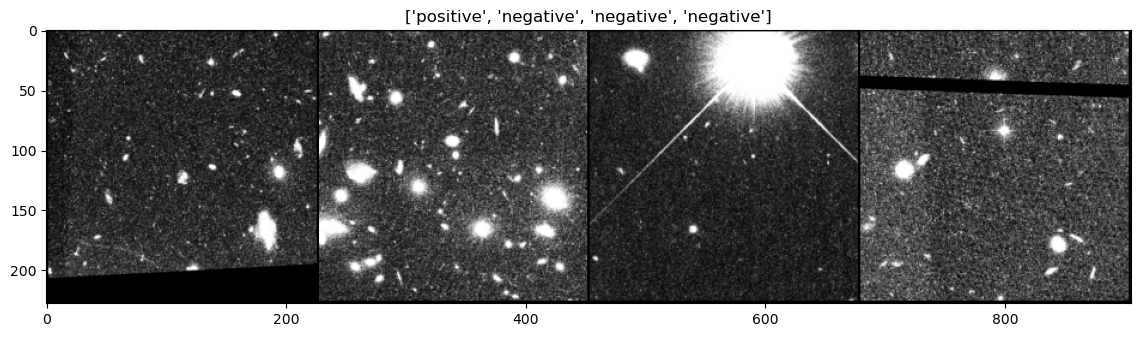

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    plt.figure(figsize=(14,8))
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap='gray', vmin=0, vmax=1)  # 指定灰度色彩映射
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=len(inputs))

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
print(model_ft)
print('-----------------------')

conv1 = model_ft.conv1
w = conv1.weight
print(w.shape)
conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
conv1.weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
print(model_ft.conv1)
print(conv1)
print('-----------------------')
model_ft.conv1 = conv1

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8906 Acc: 0.5206
val Loss: 0.8390 Acc: 0.5790

Epoch 1/24
----------
train Loss: 0.7879 Acc: 0.6540
val Loss: 0.7585 Acc: 0.6562

Epoch 2/24
----------
train Loss: 0.6505 Acc: 0.7142
val Loss: 0.5044 Acc: 0.8033

Epoch 3/24
----------
train Loss: 0.6083 Acc: 0.7478
val Loss: 0.4197 Acc: 0.8401

Epoch 4/24
----------
train Loss: 0.4296 Acc: 0.8216
val Loss: 0.4484 Acc: 0.7904

Epoch 5/24
----------
train Loss: 0.4029 Acc: 0.8363
val Loss: 0.4314 Acc: 0.8419

Epoch 6/24
----------
train Loss: 0.3158 Acc: 0.8822
val Loss: 0.4091 Acc: 0.8382

Epoch 7/24
----------
train Loss: 0.2092 Acc: 0.9243
val Loss: 0.4014 Acc: 0.8548

Epoch 8/24
----------
train Loss: 0.1932 Acc: 0.9252
val Loss: 0.3599 Acc: 0.8529

Epoch 9/24
----------
train Loss: 0.1635 Acc: 0.9465
val Loss: 0.3575 Acc: 0.8676

Epoch 10/24
----------
train Loss: 0.1599 Acc: 0.9423
val Loss: 0.3475 Acc: 0.8603

Epoch 11/24
----------
train Loss: 0.1448 Acc: 0.9513
val Loss: 0.3474 Acc: 0.8640

Ep

In [8]:
best_model_params_path = os.path.join('.\model', '9.10-1.pt')
torch.save(model_ft.state_dict(), best_model_params_path)